# Settings

### Autoreload of ipynb

In [1]:
%reload_ext autoreload
%autoreload 2

### Changing the path to the main directories path

In [2]:
import os
os.chdir(r"C:\Users\amilion\Documents\GitHub\CNRL-Cortical-Column\src")
os.getcwd()

'C:\\Users\\amilion\\Documents\\GitHub\\CNRL-Cortical-Column\\src'

# Imports

In [3]:
from conex import *
from pymonntorch import *

from matplotlib import pyplot as plt

from L56.RefrenceFrames import RefrenceFrame
from L56.stimuli.current_base import RandomInputCurrent
from InputLayer.DataLoaderLayer import DataLoaderLayer
from InputLayer.synapse.LocationCoder import LocationCoder
from L423.network.SetTarget import SetTarget

from L56.tools.visualization import refrence_frame_raster

# Configs

In [4]:
HIGHER_LAYER_DIM = 16 
REFRENCE_FRAME_DIM = 23
REFRENCE_INH_DIM = 15
ITERATIONS = 100
SCREEN_SHOT_PATH = "C:\\Users\\amilion\\Desktop\\develop\\python\\NS\\records\\L5.6"

# Defining emty DataLoader

In [5]:
class EmptyDataLoader():
    def __init__(self):
        self.dataset = torch.zeros(1, 15, 15)
        super().__init__()

dl = EmptyDataLoader()
dl.dataset

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

# Defining targets

In [6]:
target = torch.Tensor([1])

# Initializing the Network

In [7]:
net = Neocortex(index=True, dt=1, dtype=torch.float32, behavior = prioritize_behaviors(
    [
        Payoff(initial_payoff = 1),
        Dopamine(tau_dopamine = 5),
    ]
    ) | {5 : SetTarget(target = target), 601 : Recorder(["dopamine"])})

# Neuron Groups

### Defining L23

In [8]:
higher_layer = NeuronGroup(
    net=net,
    size=NeuronDimension(depth=1, height=HIGHER_LAYER_DIM, width=HIGHER_LAYER_DIM),
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            SpikeTrace(tau_s = 5, offset = 0),
            NeuronAxon(),
        ]
    )
    | (
        {
            250: RandomInputCurrent(k=2, prob_to_spike=0.2, intensity=1, T=ITERATIONS//2),
            # 600: Recorder(["I", "v"]),
            603: EventRecorder(["spikes"]),
        }
    ),
)

L23 = Layer(
    net=net, 
    neurongroups=[higher_layer], 
    input_ports={"input": (None, [Port(object=higher_layer, label=None)])}, 
    output_ports={"output":(None, [Port(object=higher_layer, label=None)])}
)

### Defining L56

In [9]:
L56 = RefrenceFrame(
    net=net, 
    k=2, 
    refrence_frame_side=REFRENCE_FRAME_DIM, 
    inhibitory_size=REFRENCE_INH_DIM,
    competize=True).build_layer()

### Defining InputLayer

In [10]:
InputLayer = DataLoaderLayer(
    net=net, 
    data_loader=dl, 
    widnow_size=1, 
    saccades_on_each_image=2, 
    rest_interval=1, 
    iterations=ITERATIONS).build_data_loader()

# Synapses

### Without Learning

In [11]:
Inp_to_L56 = Synapsis(
    net = net,
    src = InputLayer,
    dst = L56,
    input_port = "data_out",
    output_port = "input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),]) | {
        275: LocationCoder()
    },
    synaptic_tag="Proximal"
)

### With Learning

In [12]:
L23_to_L56 = Synapsis(
    net=net,
    src=L23,
    dst=L56,
    input_port="output",
    output_port="input",
    synaptic_tag="Apical, exi",
    synapsis_behavior=prioritize_behaviors(
        [
            SynapseInit(), 
            SimpleDendriticInput(),
            WeightInitializer(mode="normal(2, 0.5)"),
            SimpleSTDP(w_min=0, w_max=10, a_plus=1, a_minus=0.0008)
        ]
    )
)

L56_to_L23 = Synapsis(
    net=net,
    src=L56,
    dst=L23,
    input_port="output",
    output_port="input",
    synaptic_tag="Apical, exi",
    synapsis_behavior=prioritize_behaviors(
        [
            SynapseInit(), 
            SimpleDendriticInput(),
            WeightInitializer(mode="normal(2, 0.5)"),
            SimpleSTDP(w_min=0, w_max=10, a_plus=1, a_minus=0.0008)
        ]
    )
)

# Simulating the network

In [13]:
net.initialize()
net.simulate_iterations(ITERATIONS)

Network['Neocortex'](Neurons: tensor(1330)|5 groups, Synapses: tensor(863553)|11 groups){1:TimeResolution(dt=1,)5:SetTarget(target=tensor([1.]),)100:Payoff(initial_payoff=1,)120:Dopamine(tau_dopamine=5,initial_dopamine_concentration=None,)601:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['dopamine'],)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](256){0:NeuronDimension(depth=1,height=16,width=16,input_patterns=None,)220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)250:RandomInputCurrent(k=2,prob_to_spike=0.2,intensity=1,T=50,)360:SpikeTrace(tau_s=5,offset=0,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)603:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=

562.5901222229004

# Visualizing

### Finding the refrence Frames

In [14]:
refrences = []

for refrence in L56.neurongroups:
    if 'RefrenceFrame' in refrence.tags:
        refrences.append(refrence)

### Saving the plots

In [18]:
refrence_frame_raster(
    refrence_frame=refrences[0],
    lib = SCREEN_SHOT_PATH,
    last_itr=100,
    step=1
)

In [16]:
dir(L56_to_L23)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_mat',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_mat_eval_dict',
 '_maybe_warn_non_full_backward_hook',
 '_modules',

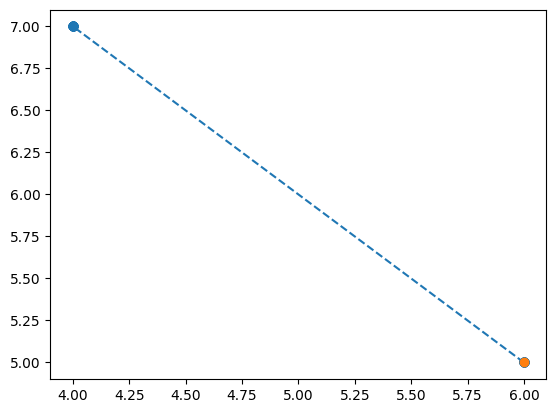

In [17]:
pos_x = InputLayer.neurongroups[0]["focus_loc", 0][:99,0]
pos_y = InputLayer.neurongroups[0]["focus_loc", 0][:99,1]

pos_x, pos_y
plt.plot(pos_x, pos_y, '--o')
plt.plot(pos_x[0], pos_y[0], 'o')